In [326]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (mean_squared_error, accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, auc)
import numpy as np
import pandas as pd
import ast
import seaborn as sns

# Predicting jobs
The NYU centre for data science hosted a project exposition where gunning data scientists could come up and present analytical projects in front of industry professionals and fellow students. Propelled by our frustrations with the internship job search, a friend and I attempted to develop a predictor that could determine whether a user would be accepted into a job based on a list of skills a user provided. And despite only being able to produce an SVM model with 60% accuracy, we walked away from the expo with constructive feedback on how we could improve moving forward. *For my Data Bootcamp final*, I decided to build on the job predictor. Note that for time's sake, *this notebook will only be using a sample* of the actual dataset with the sample only containing four thousand datapoints. 

### Footnotes
The dataset was already mostly preprocessed, so to shorten this notebook that will mostly be left out: Numeric NaN values were replaced with zeroes, Qualitative NaN values were replaced on a case by case scenario, duplicate jobs were merged to form lists in certain columns. The original models can also be uploaded for reference, but everything here on out will be completely new work taking from the models and concepts learnt in class.

The threshold value for the classifier (for now) will be whether an applicant gets above or below the 75th percentile in salary: getting above that percentile would mean that you get the job. So really this is a glorified income predictor.

## Critique one: Better data preparation
There were many flaws in the initial data loading and preparation. For this reason, data cleaning was redone but with a more refined approach that involved, for the most part, much cleaner groupby functions that merged skills and industries into lists for every job. The resulting dataframe went from several million datapoints to a few hundred thousand with 93 columns.

### Cutting out columns
While being a potentially shortsighted approach, features with a very low linear correlation (<0.1) were dropped on the basis that they were unnecessary to keep and to reduce dimensionality. My end goal is to conduct dimensionality reduction and feature engineering with a PCA.

Jobs with either a maximum or minimum salary do not have a median salary attached and vice versa. Let's take a look and see whether there is any discernible difference between those jobs.

In [327]:
data = pd.read_csv('../Cleaning/Cleaned_mini_dataset_for_bootcamp.csv')

In [328]:
# Filter jobs with median salary only (no max or min salary)
median_only_jobs = data[(data['med_salary_x'].notna()) & (data['max_salary_x'].isna()) & (data['min_salary_x'].isna())]

# Filter jobs with max or min salary posted
max_min_salary_jobs = data[(data['max_salary_x'].notna()) | (data['min_salary_x'].notna())]

# Compare basic statistics between the two groups
median_stats = median_only_jobs.describe(include='all')
max_min_stats = max_min_salary_jobs.describe(include='all')

# Display results to the user
median_stats, max_min_stats

(         Unnamed: 0 company_name_x                          title_x  \
 count    367.000000            367                              367   
 unique          NaN            201                              327   
 top             NaN        PepsiCo  Customer Service Representative   
 freq            NaN             17                                7   
 mean    3782.795640            NaN                              NaN   
 std     2275.314116            NaN                              NaN   
 min       31.000000            NaN                              NaN   
 25%     1860.000000            NaN                              NaN   
 50%     3802.000000            NaN                              NaN   
 75%     5711.000000            NaN                              NaN   
 max     7860.000000            NaN                              NaN   
 
                                           description_x_x  max_salary_x  \
 count                                                 367

Significantly more jobs with max/min pay information, and these jobs are more diverse and tend to involve larger companies with annual instead of hourly pay periods.
Hourly vs. Yearly Pay: Median-only jobs are typically hourly roles, while max/min salary jobs tend to be yearly roles.
Industry and Size: Median-only jobs are more focused on smaller companies and specific sectors, while max/min salary jobs span a wider range of industries and include larger companies.

For these reasons, I am going to cut out any job with median salary information as the initial predictor was catered towards students looking for white-collared jobs. I will also hand-pick meaningless columns to drop, as many columns are present due to the initial merging of datasets to generate this. Anything with the x suffix came from company data, y from job specific.

In [329]:
# Drop rows where max_salary_x is null 
data = data.dropna(subset=['max_salary_x']).reset_index(drop=True)
data.dropna(axis=1,how='all', inplace=True)

In [330]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 0 to 2298
Data columns (total 73 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    2299 non-null   int64  
 1   company_name_x                2296 non-null   object 
 2   title_x                       2299 non-null   object 
 3   description_x_x               2299 non-null   object 
 4   max_salary_x                  2299 non-null   float64
 5   pay_period_x                  2299 non-null   object 
 6   location_x                    2299 non-null   object 
 7   min_salary_x                  2299 non-null   float64
 8   formatted_work_type_x         2299 non-null   object 
 9   remote_allowed_x              2299 non-null   object 
 10  job_posting_url_x             2299 non-null   object 
 11  application_url_x             2299 non-null   object 
 12  application_type_x            2299 non-null   object 
 13  clo

In [331]:
columns_to_drop = ['industry_id', 'currency_y', 'skill_abr', 'url_x', 'address_x', 'name_x', 'job_posting_url_x', 'location_x', 'skills_desc_x', 'posting_domain_x', 'currency_x', 'zip_code_y_x', 'job_posting_url_y', 'application_url_y', 'application_type_y', 'posting_domain_y', 'skills_desc_y', 'work_type_y', 'inferred_y', 'company_size_y', 'address_y', 'url_y', 'application_url_x', 'description_x_y', 'name_y', 'description_y_y', 'zip_code_y_y', 'Unnamed: 0', 'formatted_experience_level_y', 'country_y', 'location_y', 'state_y', 'company_name_y', 'max_salary_x', 'min_salary_x', 'pay_period_x', 'remote_allowed_x', 'closed_time_x', 'sponsored_x', 'compensation_type_x', 'type_x', 'city_x', 'employee_count_x', 'follower_count_x', 'industry_name_x', 'skill_name_x', 'formatted_work_type_x', 'type_x', 'title_y']
data.drop(columns_to_drop, axis=1, inplace=True)

In [332]:
# Rename columns to be more readable
new_column_names = {
    'company_name_x': 'Company Name',
    'title_x': 'Job Title',
    'description_x_x': 'Job Description',
    'formatted_work_type_x': 'Work Type',
    'application_type_x': 'Application Type',
    'formatted_experience_level_x': 'Experience Level',
    'work_type_x': 'Work Category',
    'inferred_x': 'Inferred Data',
    'description_y_x': 'Company Description',
    'company_size_x': 'Company Size',
    'state_x': 'State',
    'country_x': 'Country',
    'title_y': 'Alt Job Title',
    'max_salary_y': 'Max Salary',
    'pay_period_y': 'Pay Period',
    'min_salary_y': 'Min Salary',
    'formatted_work_type_y': 'Alt Work Type',
    'remote_allowed_y': 'Remote Allowed',
    'closed_time_y': 'Closed Time',
    'sponsored_y': 'Sponsored',
    'compensation_type_y': 'Compensation Type',
    'type_y': 'Benefits',
    'city_y': 'City',
    'employee_count_y': 'Employee Count',
    'follower_count_y': 'Follower Count',
    'skill_name_y': 'Skills',
    'industry_name_y': 'Industries'
}

# Rename columns in the DataFrame
data.rename(columns=new_column_names, inplace=True)

# Dropping internships because of sparsity in this dataset
data = data[~data['Experience Level'].str.contains('Internship', case=False, na=False)]
data = data[~data['Experience Level'].str.contains('Not Specified', case=False, na=False)]

In [333]:
data.head(20)

,Company Name,Job Title,Job Description,Application Type,Experience Level,Work Category,Inferred Data,Company Description,Company Size,State,...,Remote Allowed,Closed Time,Sponsored,Compensation Type,Benefits,City,Employee Count,Follower Count,Skills,Industries
0,techolution,Robotics Manufacturing engineer,We are seeking a skilled Robotics Manufacturin...,ComplexOnsiteApply,Mid-Senior level,FULL_TIME,0.0,Techolution is a leading innovation consulting...,3.0,New York,...,Unknown,Still Open,0,BASE_SALARY,401(k),New York,452.0,299691.0,['Production'],['Medical Equipment Manufacturing']
1,LHH,Senior Network Engineer (RELO AVALIBLE),LHH Technology is seeking a Senior Network Eng...,ComplexOnsiteApply,Mid-Senior level,FULL_TIME,0.0,Welcome to LHH!\n\nWe're a global leader in HR...,7.0,Florida,...,Unknown,Still Open,0,BASE_SALARY,Disability insurance,Jacksonville,13663.0,2478006.0,['Information Technology'],['IT Services and IT Consulting']
2,CDW,Principal Engineer,The Principal Consultant is a client facing te...,ComplexOnsiteApply,Mid-Senior level,FULL_TIME,0.0,"At CDW, our experts partner with you to build ...",7.0,IL,...,1.0,Still Open,0,BASE_SALARY,Disability insurance,Vernon Hills,17652.0,233653.0,"['Engineering', 'Consulting', 'Information Tec...","['Business Consulting and Services', 'IT Servi..."
3,Calculated Hire,Associate Account Executive,"Launched in 2000, Eight Eleven Group committed...",ComplexOnsiteApply,Entry level,FULL_TIME,0.0,Talent Delivery. Modernized.\n\nHere at Calcul...,2.0,IN,...,Unknown,Still Open,0,BASE_SALARY,Dental insurance,Indianapolis,108.0,208604.0,"['Business Development', 'Sales']","['Staffing and Recruiting', 'Business Consulti..."
5,techolution,Sr Robotics Manufacturing Engineer,Techolution is looking for a smart and dynamic...,ComplexOnsiteApply,Mid-Senior level,FULL_TIME,0.0,Techolution is a leading innovation consulting...,3.0,New York,...,Unknown,Still Open,0,BASE_SALARY,Medical insurance,New York,453.0,300077.0,"['Manufacturing', 'Production', 'Engineering']","['Warehousing and Storage', 'Medical Equipment..."
6,LHH,Billing Analyst,Do you live in San Diego and have interest in ...,SimpleOnsiteApply,Associate,FULL_TIME,0.0,Welcome to LHH!\n\nWe're a global leader in HR...,7.0,Florida,...,Unknown,Still Open,0,BASE_SALARY,Medical insurance,Jacksonville,13651.0,2476415.0,"['Accounting/Auditing', 'Finance', 'Analyst']","['Services for Renewable Energy', 'Professiona..."
7,T-Mobile,"Manager, Cybersecurity Engineering",Be unstoppable with us!\n\nT-Mobile is synonym...,OffsiteApply,Mid-Senior level,FULL_TIME,1.0,"T-Mobile US, Inc. (NASDAQ: TMUS) is America’s ...",7.0,WA,...,Unknown,Still Open,0,BASE_SALARY,Disability insurance,Bellevue,86861.0,539291.0,['Information Technology'],['Telecommunications']
8,Russell Tobin,Human Resources Business Partner,Russell Tobin & Associates is currently seekin...,ComplexOnsiteApply,Mid-Senior level,CONTRACT,1.0,Bring Top Talent With Your Company With Russel...,3.0,New York,...,Unknown,Still Open,0,BASE_SALARY,401(k),New York,597.0,614163.0,"['Human Resources', 'Legal']","['Hospitals and Health Care', 'Public Health']"
9,Insight Global,Software Engineering Supervisor,"A client in Los Angeles, CA are seeking a skil...",ComplexOnsiteApply,Mid-Senior level,FULL_TIME,0.0,Insight Global is an international staffing an...,5.0,Georgia,...,Unknown,Still Open,0,BASE_SALARY,Paid maternity leave,Atlanta,14134.0,2424499.0,"['Management', 'Engineering', 'Information Tec...","['Software Development', 'Hospitals and Health..."
10,Amazon,"Production Manager, Amazon Publishing Global",Description\n\nAmazon Publishing is looking fo...,OffsiteApply,Mid-Senior level,FULL_TIME,Unknown,Amazon is guided by four principles: customer ...,7.0,WA,...,Unknown,Still Open,0,BASE_SALARY,Not Specified,Seattle,749112.0,30761659.0,['Management'],['Software Development']


In [334]:
pay_periods = data['Pay Period'].unique()
print(pay_periods)

['YEARLY' 'HOURLY' 'MONTHLY' 'WEEKLY']


In [335]:
# Keeping yearly jobs as these are more representative of relevant jobs to us students.
data = data[data['Pay Period'] == 'YEARLY']

## Critique two: Better EDA
Now that the columns have been tidied up, we learned that it's best to develop a more intimate EDA. Not only will this allow us to gauge the underlying relationships, but it will ultimately allow us to build a better model.


As was already alluded to earlier, we are using salaries as a stand-in for whether an applicant is accepted into a job or not by assuming that salaries are a good indication of quality. Despite being a simplistic approach, it was our best alternative accounting for the fact that LinkedIn does not provide recruiting data.

From the previous analysis, I remember that the data was very skewed, so I will be taking the interquartile range to remove outliers.

In [336]:
data = data[data['Country'] == 'US']

Q1 = data['Max Salary'].quantile(0.25)
Q3 = data['Max Salary'].quantile(0.75)
IQR = Q3 - Q1

# Filter based on the IQR range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['Max Salary'] >= 10000) & (data['Max Salary'] <= upper_bound)]

# Turning Skills and Industries rows back into lists
data['Skills'] = data['Skills'].apply(lambda x: eval(x) if isinstance(x, str) else [])
data['Industries'] = data['Industries'].apply(lambda x: eval(x) if isinstance(x, str) else [])

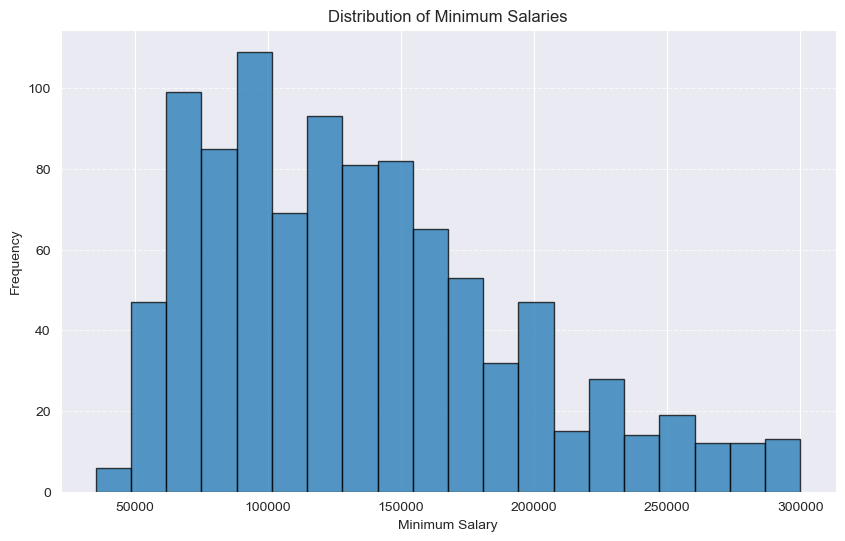

In [337]:
plt.figure(figsize=(10, 6))
plt.hist(data['Max Salary'], bins=20, alpha=0.75, edgecolor='black')
plt.title('Distribution of Minimum Salaries')
plt.xlabel('Minimum Salary')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Salaries will be the target variable in the classifier so it would make sense to look at its distribution. Whilst it is not very evident here, the actual distribution is far more normal with a slight right skew.

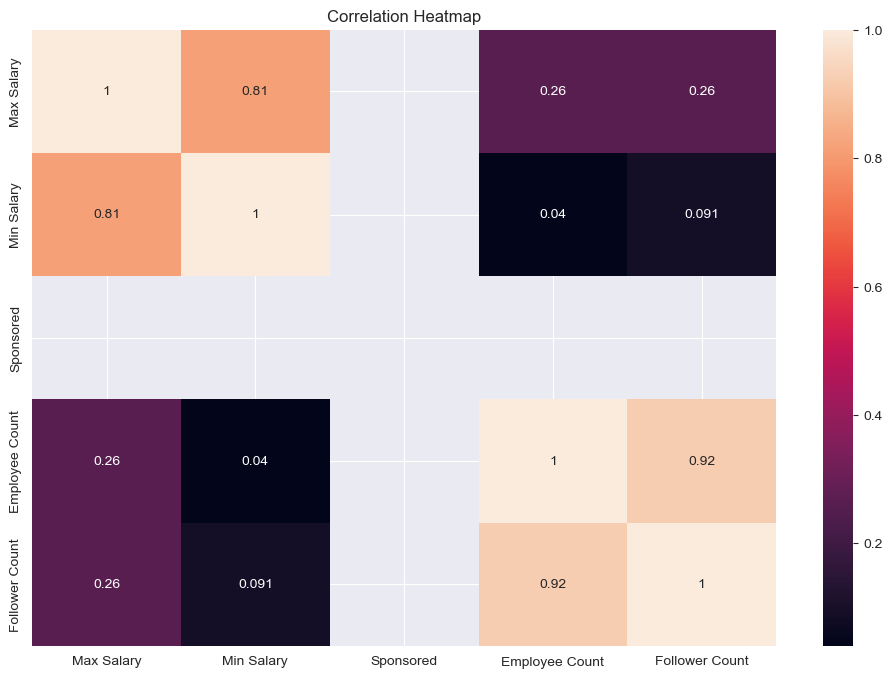

In [338]:
numeric_data = data.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [339]:
# Upon further inspection, the originL dataset has extremely few sponsored job postings. So for now I will remove this column
data.drop('Sponsored', axis=1, inplace=True)

Other than the fact that the sponsored column only contains one value, company employee count, Linkedin follower count and minimum salaries all have positive correlations with max salary. Keep in mind that employee count and follower counts are very heavily correlated, and that minimum salaries are less correlated with the other variables.

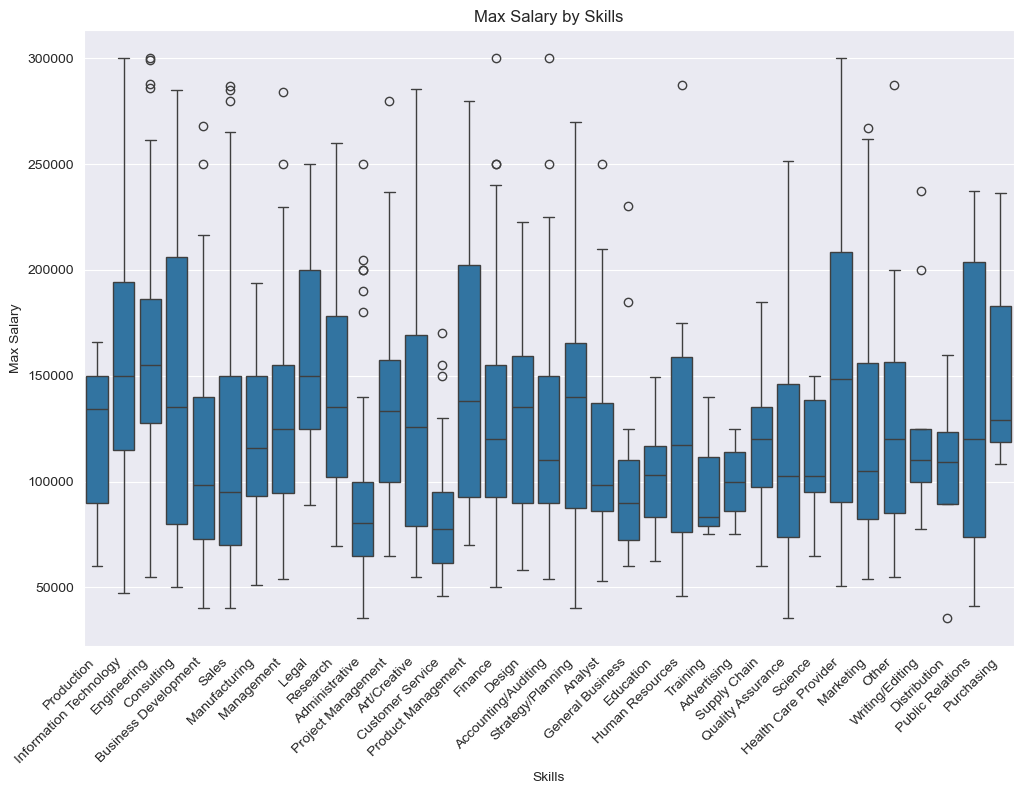

In [340]:
# Define plotting function for lists
def plot_list_column_vs_salary(column, title):
    exploded = data.explode(column).reset_index(drop=True)
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=exploded, x=column, y='Max Salary')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Max Salary by {title}')
    plt.show()

# Plot Skills vs. Max Salary
plot_list_column_vs_salary('Skills', 'Skills')

Here we have the distribution of maximum salaries for each of the 35 unique skills in the dataset. It can be seen that some skills are more conducive to higher salaries than others, where some skills like 'administrative' or 'customer service' have much lower median salaries.

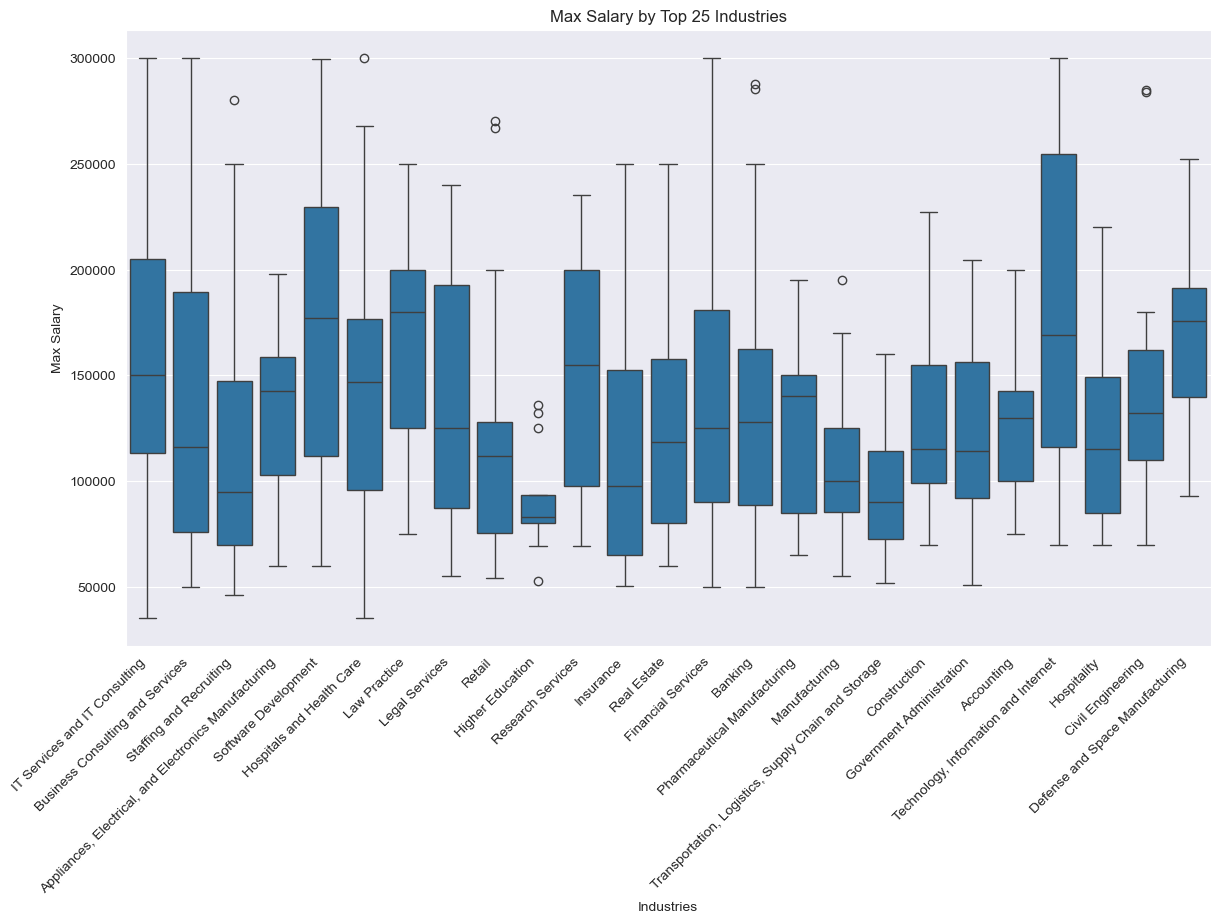

In [341]:
# Top 10 industries by occurrence
top_industries = data.explode('Industries')['Industries'].value_counts().head(25).index

# Filter only top industries
filtered_data = data.explode('Industries')
filtered_data = filtered_data[filtered_data['Industries'].isin(top_industries)]

# Replot with filtered data
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_data, x='Industries', y='Max Salary')
plt.xticks(rotation=45, ha='right')
plt.title('Max Salary by Top 25 Industries')
plt.show()

There are many more unique industries than skills because skills were inferred from job descriptions and industries were explicitly listed on the postings, so it is something to do with the way data was initially scraped. That said, we see that there is again a wide distribution of salaries by industry with 'Entertainment Providers' for example earning much more than other industries like 'Manufacturing'.

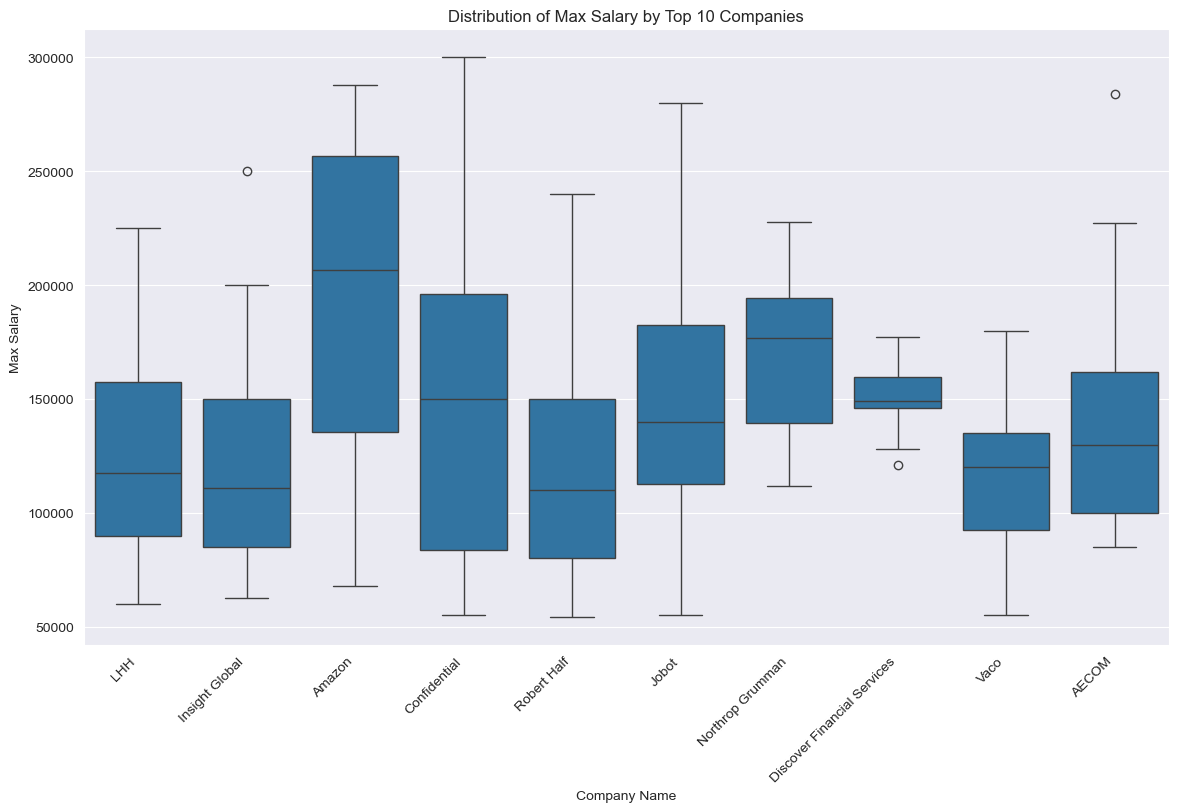

In [342]:
# Identify the top 10 most frequently occurring companies
top_10_companies = data['Company Name'].value_counts().head(10).index

# Filter the data to include only the top 10 companies
top_companies_data = data[data['Company Name'].isin(top_10_companies)]

# Plot the boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=top_companies_data, x='Company Name', y='Max Salary')

plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Max Salary by Top 10 Companies')
plt.xlabel('Company Name')
plt.ylabel('Max Salary')
plt.show()

Amazon being the huge company it is stands as an outlier in company size, so I ended up plotting boxplots instead.

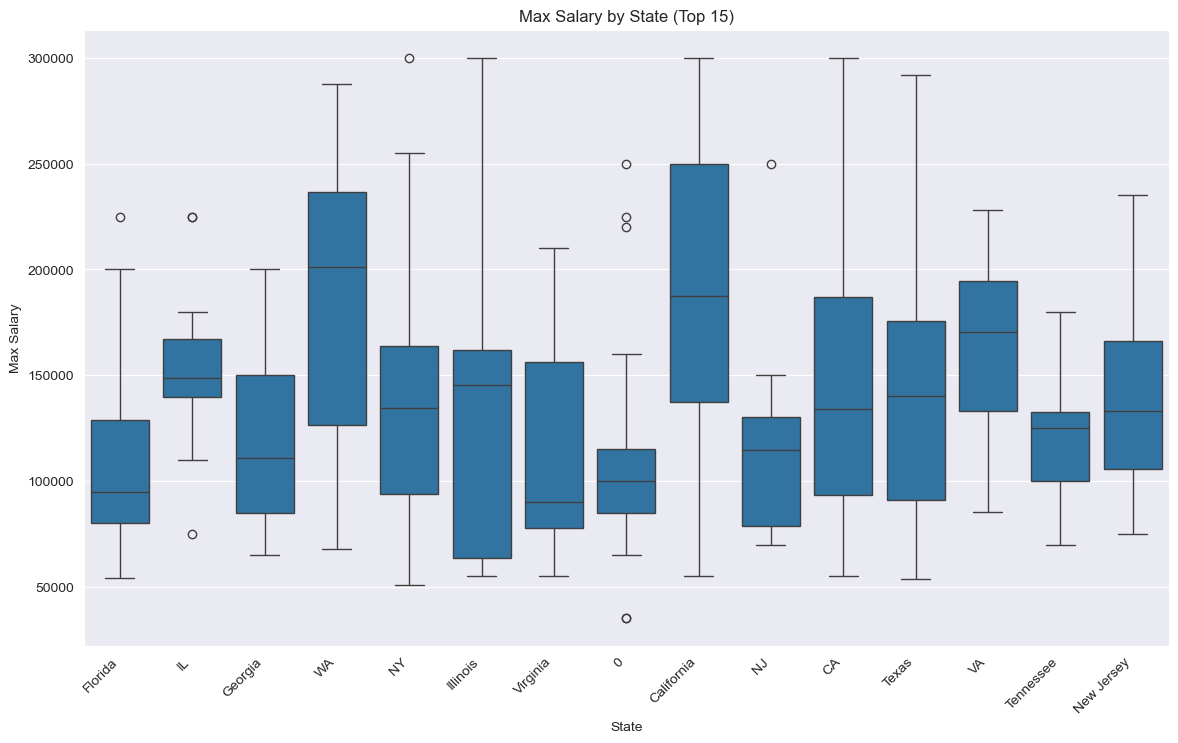

In [343]:
top_states = filtered_data['State'].value_counts().head(15).index
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_data[filtered_data['State'].isin(top_states)], 
            x='State', y='Max Salary')
plt.xticks(rotation=45, ha='right')
plt.title('Max Salary by State (Top 15)')
plt.show()

Remember to account for different naming conventions e.g. New York vs NY.
Rememember that in dataset generation NaN states were filled with 0 hence that label.

In [344]:
# Checking column names
data.columns

Index(['Company Name', 'Job Title', 'Job Description', 'Application Type',
       'Experience Level', 'Work Category', 'Inferred Data',
       'Company Description', 'Company Size', 'State', 'Country', 'Max Salary',
       'Pay Period', 'Min Salary', 'Alt Work Type', 'Remote Allowed',
       'Closed Time', 'Compensation Type', 'Benefits', 'City',
       'Employee Count', 'Follower Count', 'Skills', 'Industries'],
      dtype='object')

One huge realisation my teammate and I made after conducting linear analysis was that many skills were inferred with higher level jobs. For example, executive IT jobs would no longer have IT have a listed skill primarily because it is already assumed, which would explain many of the negative coefficients we were extracting. Below are some plots to try and discern any relationship we could try and control for.

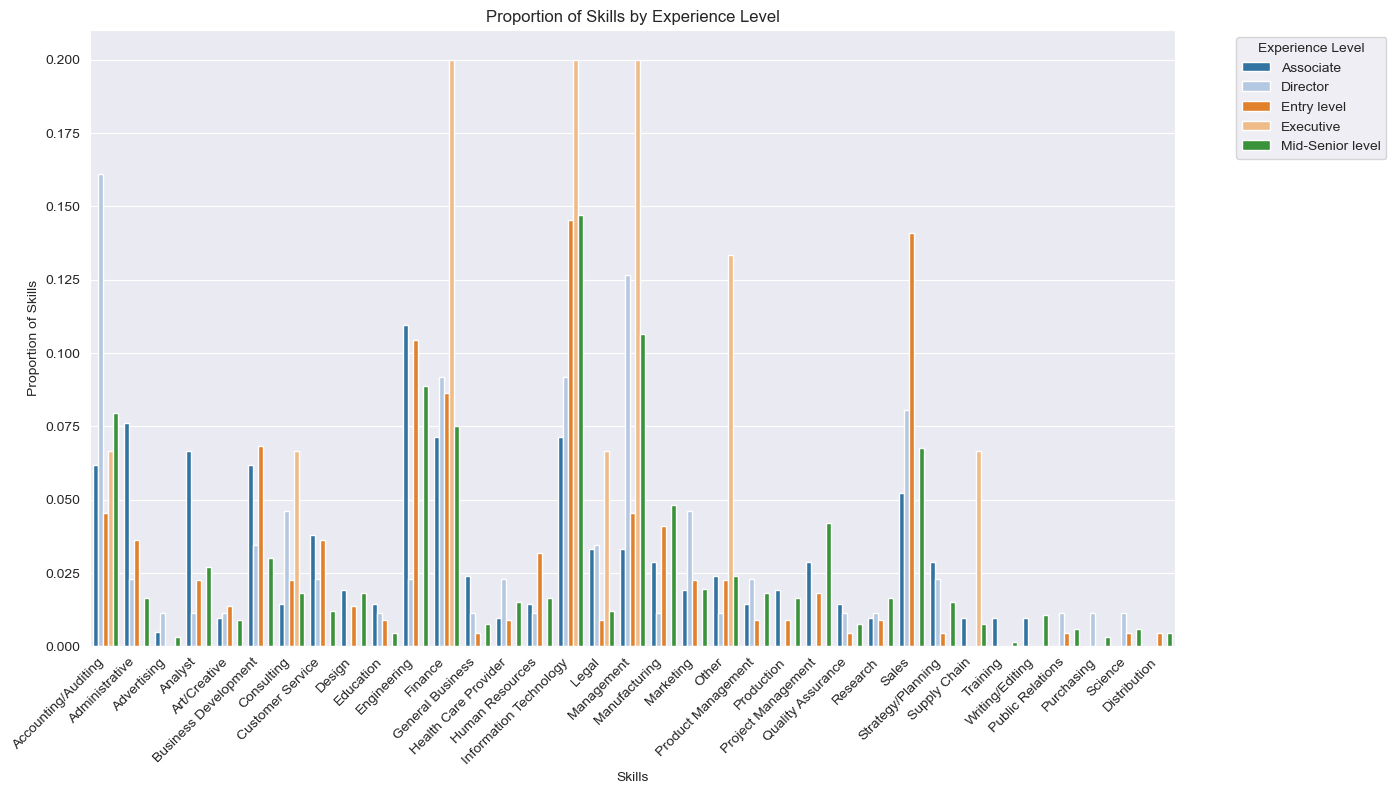

In [345]:
# Explode the 'Skills' column to create one skill per row
exploded_skills = data.explode('Skills').dropna(subset=['Skills'])

# Calculate proportions of skills by Experience Level
skill_counts = exploded_skills.groupby(['Experience Level', 'Skills']).size().reset_index(name='Count')
skill_totals = skill_counts.groupby('Experience Level')['Count'].transform('sum')
skill_counts['Proportion'] = skill_counts['Count'] / skill_totals

# Plot proportional distribution
plt.figure(figsize=(14, 8))
sns.barplot(data=skill_counts, x='Skills', y='Proportion', hue='Experience Level', palette='tab20')

plt.xticks(rotation=45, ha='right')
plt.title('Proportion of Skills by Experience Level')
plt.ylabel('Proportion of Skills')
plt.xlabel('Skills')
plt.legend(title='Experience Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

More executive roles tend to showcase less skills to a greater extent – skills like finance, management, IT and supply chain skills. But other than that it is hard to tell whether there is any real difference in skills required across experience levels.

Note that there are only 35 unique skills in the entire dataset. 

## Critique three: Better encoding

### Multi-hot encoding

In the first attempt, my teammate and I exploded the dataframe instead of encoding the list columns when trying to represent them visually. We were recommended to try and multi-hot encode the data because it works well for multi-label features. This allows us to easily compute a matrix correlation without having to re-aggregate and interpret our results. There is also the added benefit of keeping each job confined to a single row, which is important because we will not be skewing the data towards job postings with a lot of skills listed.

<Figure size 1600x1200 with 0 Axes>

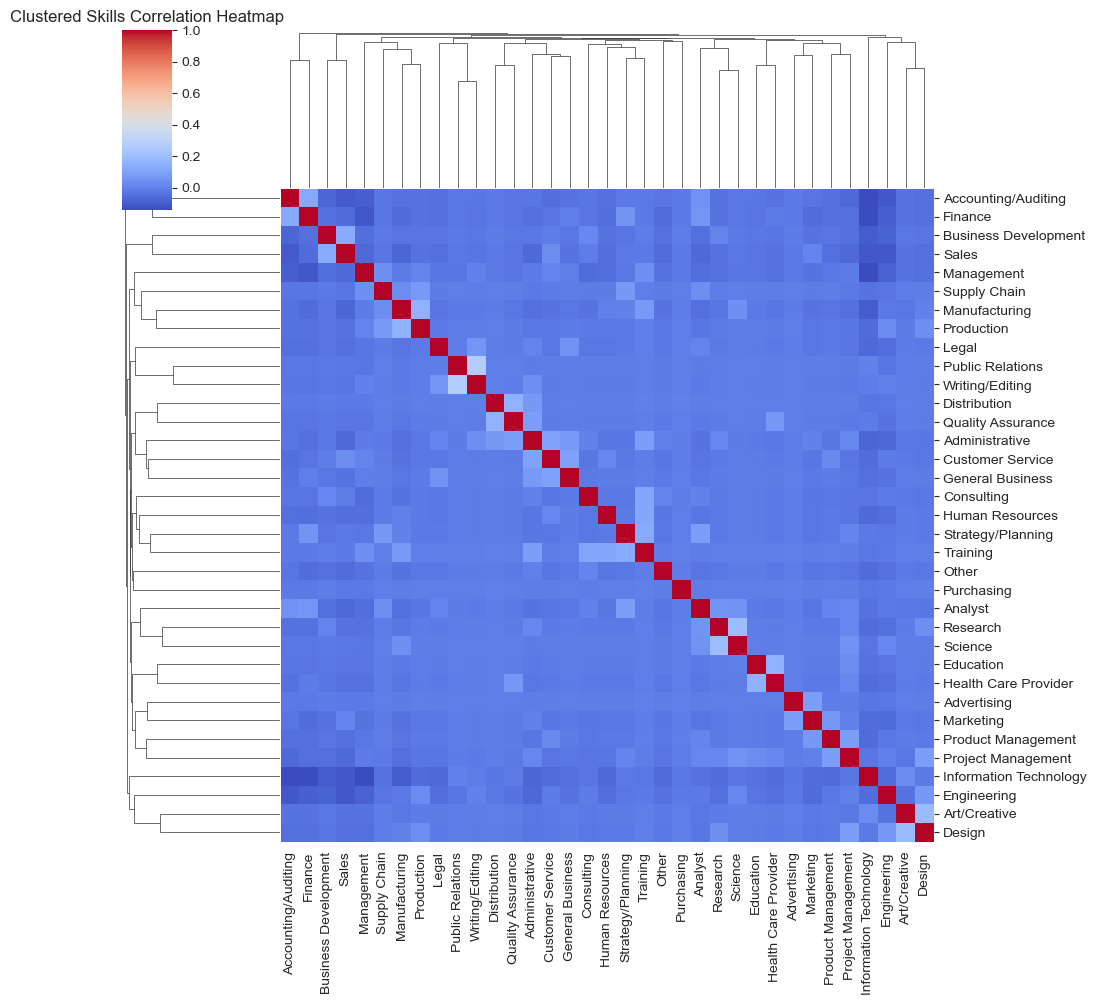

In [346]:
# Convert the 'Skills' column into a multi-hot encoded matrix
skills_encoded = data['Skills'].str.join('|').str.get_dummies()

# Compute the correlation matrix
skills_correlation_matrix = skills_encoded.corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.clustermap(skills_correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Clustered Skills Correlation Heatmap')
plt.show()


<Figure size 1600x1200 with 0 Axes>

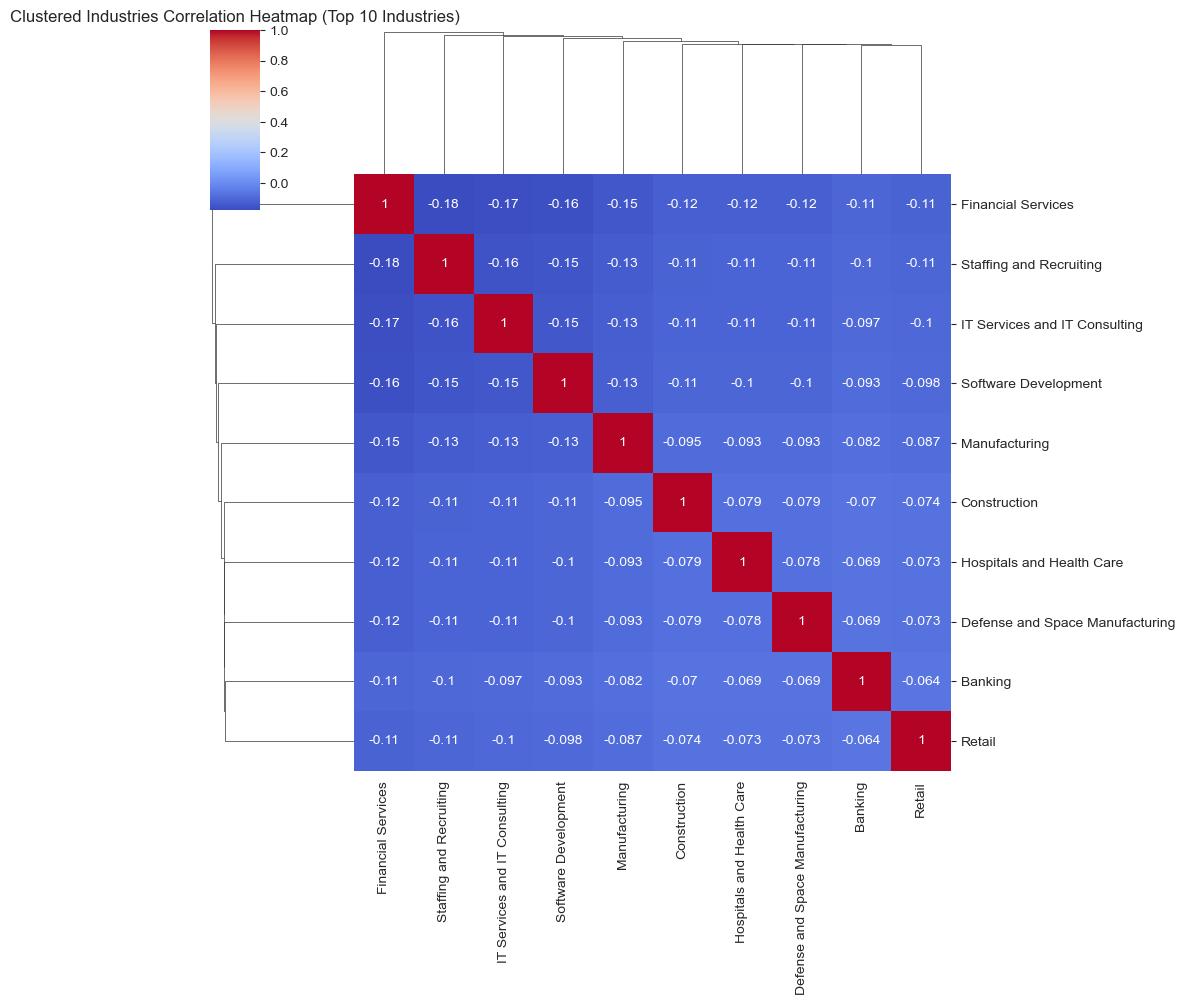

In [347]:
# Identify the top 10 most frequently occurring industries
exploded_industries = data.explode('Industries')
top_10_industries = exploded_industries['Industries'].value_counts().head(10).index

# Filter only rows with industries in the top 10 list
filtered_industries = exploded_industries[exploded_industries['Industries'].isin(top_10_industries)]

industries_encoded = filtered_industries['Industries'].str.get_dummies()
industries_correlation_matrix = industries_encoded.corr(method='pearson')
plt.figure(figsize=(16, 12))
sns.clustermap(industries_correlation_matrix, cmap='coolwarm', annot=True, method='ward')
plt.title('Clustered Industries Correlation Heatmap (Top 10 Industries)')
plt.show()

Not much (linear) relationship between feature presence in both cases. This suggests that not much feature reduction can be done and that we have to include all of these features individually.

### Trying a PCA
The goal was to see whether we could conduct a PCA to reduce the dimensionality of our dataset. The correlation matricies above suggest that there is weak potential for dimensionality reduction through PCA due to lack of collinearity among data.


In [348]:
# Reset index for alignment
skills_encoded = skills_encoded.reset_index(drop=True)
industries_encoded = industries_encoded.reset_index(drop=True)

# Concatenate the two matrices
X = pd.concat([skills_encoded, industries_encoded], axis=1)
X = X.fillna(0) # Just in case

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Scaling the data because PCA is sensitive to outliers
X_scaled = scaler.fit_transform(X)

In [349]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95) # I want to account for 95% of the variance. Make sure to check for elbows.
X_pca = pca.fit_transform(X_scaled)

Original shape of data: (981, 45)
Reduced shape after PCA: (981, 41)


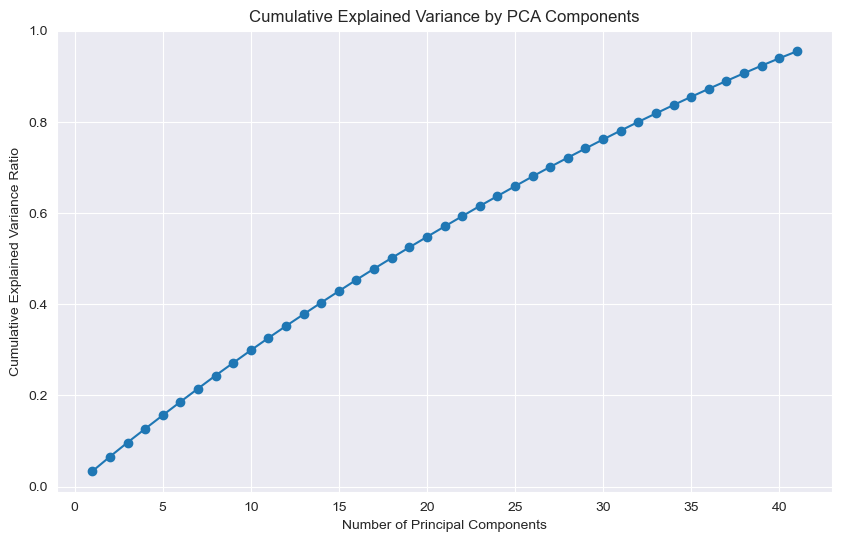

In [350]:
# Print results
print("Original shape of data:", X_scaled.shape)
print("Reduced shape after PCA:", X_pca.shape)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Cumulative Explained Variance by PCA Components")
plt.grid(True)
plt.show()

The PCA results indicate that the original 45-dimensional dataset was only reduced to 41 components while retaining 95% of the variance, highlighting minimal redundancy and an inherently high-dimensional structure. The absence of a clear "elbow point" and the near-linear cumulative variance increase suggest that the variance is evenly distributed across features, making PCA ineffective for significant dimensionality reduction. This is likely due to the sparse and distributed nature of the skills and industries data.

# Critique four: Try a different model: RF Classifiers

A random forest classifier was deployed for several reasons:
High dimensionality
High number of categorical features
Non-linear relationships between categories and the target. It is highly unlikely that job features and the likelihood of receiving high paying jobs is linear.
Ease of feature interpretation.
Robustness to missing data.

Minimum salary was removed as a predictor and so was job title. Job title was removed because of the variation in naming conventions as well as the fact that we are not actually predicting acceptance but incomes - so including job title would be cheating almost.

(Two functions and a main call function were built because I designed them to be used in .py files and not notebooks.)


In [351]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

This was run on the mega dataset

---
/opt/anaconda3/envs/my_env/bin/python /Users/adrianeddy/PycharmProjects/EXPO 2024/Data Bootcamp final/Big Boy.py 
Loading dataset...
Handling missing values...
Encoding categorical features...
Scaling numeric features...
Splitting data into train and test sets...
Training Random Forest Classifier...

Accuracy: 81.82%

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      1479
           1       0.69      0.42      0.52       457

    accuracy                           0.82      1936
   macro avg       0.76      0.68      0.70      1936
weighted avg       0.80      0.82      0.80      1936


Top 10 Important Features:
                Feature  Importance
1       Job Description    0.136921
19       Follower Count    0.118936
18       Employee Count    0.114913
20               Skills    0.101771
3      Experience Level    0.083281
21           Industries    0.073344
17                 City    0.068568
0          Company Name    0.067137
6   Company Description    0.064551
8                 State    0.060915

Process finished with exit code 0

---

Accuracy went up to 82%, meaning that 82% of the time we are able to correctly guess someone who earns more than the 3rd percentile.


### Interpretation
Now that we are accounting for more features in the dataset the model is much more accurate in predicting high paying jobs.

However, obvious indicators of salary like experience level have very low feature importance while other more ambiguous predictors like description have high importance. This likely boils down to how the data was being handled. In particular, label encoding highly granular features like description effectively generates a new identifier for every instance to be then interpreted by the model as something significant.

To be frank, I do not understand rf classifiers and encoding techniques enough to break this down much further. But I have a few ideas that I will try and implement:

*Text classification:* Inspired by our class on text classification and rnn techniques, I will try and implement TF-IDF vectorisation to emphasize specific words while downplaying overly common terms so the model can infer higher level insights about certain key words that can effect salary levels without turning each one into a one-off.

*Encoding the lists*: What we did initially with our predictor was binarise the presence of each possible skill or industry effectively **one-hot encoding** each one. This approach was ok, the primary drawback being overfitting and extremely high dimensionality and sparsity. For this reason, I will encode only the top 10 most fequently occurring skills and industries thereby avoiding an imminent explosion of my feature space.

# Text Classification with RF classifier

In [352]:
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess_data(data, target_column):
    """
    Preprocesses the dataset:
    - Creates a binary target based on the 75th percentile of the target column.
    - Applies TF-IDF to 'Job Description'.
    - Label encodes other categorical features.
    - Scales numeric features.
    """

    # Create binary classification target
    threshold_salary = data[target_column].quantile(0.75)
    data[target_column] = (data[target_column] >= threshold_salary).astype(int)

    # Extract job descriptions
    job_descriptions = data['Job Description'].fillna('')

    # Drop unnecessary columns, including target, to form feature set
    X = data.drop(columns=[target_column, 'Min Salary', 'Job Title', 'Job Description'])
    y = data[target_column]

    # Label-encode other categorical features
    label_encoders = {}
    cat_cols = X.select_dtypes(include='object').columns
    for col in cat_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

    # Apply TF-IDF to job descriptions
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(job_descriptions)
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # Scale numeric columns
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    # Combine numeric/categorical features with TF-IDF features
    X_final = pd.concat([X.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

    return X_final, y, label_encoders

def train_random_forest(X, y):
    """
    Splits the data into train-test sets, trains a Random Forest Classifier,
    and evaluates it using accuracy, precision, recall, F1-score, and a classification report.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    print("\nAccuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print("Precision: {:.2f}%".format(precision_score(y_test, y_pred) * 100))
    print("Recall: {:.2f}%".format(recall_score(y_test, y_pred) * 100))
    print("F1 Score: {:.2f}%".format(f1_score(y_test, y_pred) * 100))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    feature_importances = pd.DataFrame(
        {'Feature': X.columns, 'Importance': rf_classifier.feature_importances_}
    ).sort_values(by='Importance', ascending=False)

    print("\nTop 10 Important Features:")
    print(feature_importances.head(10))

    return rf_classifier, feature_importances

def main():
    target_column = "Max Salary"
    # Ensure 'data' is defined prior to this call. For example:
    # data = pd.read_csv('your_data.csv')

    try:
        X, y, label_encoders = preprocess_data(data, target_column)
        rf_model, feature_importances = train_random_forest(X, y)
    except KeyError as e:
        print(e)

In [353]:
main()


Accuracy: 84.77%
Precision: 100.00%
Recall: 34.78%
F1 Score: 51.61%

Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91       151
           1       1.00      0.35      0.52        46

    accuracy                           0.85       197
   macro avg       0.92      0.67      0.71       197
weighted avg       0.87      0.85      0.82       197


Top 10 Important Features:
                 Feature  Importance
717             practice    0.008214
146                   ca    0.007448
15                  City    0.005855
17        Follower Count    0.005537
605              mission    0.005511
532           leadership    0.005020
935                 team    0.004758
357               equity    0.004665
16        Employee Count    0.004660
5    Company Description    0.004637


With big dataset:

---
/opt/anaconda3/envs/my_env/bin/python /Users/adrianeddy/PycharmProjects/EXPO 2024/Data Bootcamp final/Big Boy.py 
Loading dataset...

Accuracy: 83.68%
Precision: 87.70%
Recall: 35.89%
F1 Score: 50.93%

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90      1479
           1       0.88      0.36      0.51       457

    accuracy                           0.84      1936
   macro avg       0.85      0.67      0.71      1936
weighted avg       0.84      0.84      0.81      1936


Top 10 Important Features:
            Feature  Importance
848           scale    0.011311
909        strategy    0.009020
27              200    0.008093
358          equity    0.007622
18   Follower Count    0.007562
526      leadership    0.007294
17   Employee Count    0.006749
523            lead    0.006245
907       strategic    0.006158
932           teams    0.005699

---

### Interpretation:
The model's performance indicates strong predictive ability for the majority class (jobs not classified as high-paying), with an accuracy of 84.77% and a perfect precision score of 100% for the high-paying class. However, its recall for the high-paying class is only 34.78%, leading to an F1 score of 51.61%.

The most important features driving the model are just terms. Terms like "practice," "mission," and "leadership" from the job description, alongside company-specific metrics like "Follower Count" and "Employee Count."

# Conclusion and next steps

The results indicate that while the model achieves a high overall accuracy and a flawless precision for the positive class, it struggles to recall those positive cases, capturing only around a third of them. This pattern suggests the presence of class imbalance or thresholding issues. Essentially, the model is playing it safe—opting to primarily predict the majority class to maintain accuracy—at the expense of identifying enough minority class samples.

Possible fixes:
Class rebalancing. If I were to redo this analysis I would undersample the majority class.
Text classigification refinement: Although TF-IFD has improved the model overall, it may introduce noise. To solve this, I found that I could investigate additional domain-relevant features and consider dimensionality reduction here because we are looking at 1000 max features.
Hyperparameter tuning for the random forest through a grid search to find an optimal 'max_depth' for example.

I also was unable to one-hot encode the industries and skills columns due to the already complex nature of the dataframe after all of this preprocessing. So that is something else that will need to be addressed moving forward.

There is also the other issue of feature importance. The top 10 most important features are all individual words from job descriptions which means that we have the same issue as before where the high dimensionality of textual features means that our rf classifier over-exaggerates their collective presence. Deciphering better ways of how to preprocess this is outside of my domain as of this moment so to be candid I am a little stuck with this project right now.
